# B(N)PO :: 3rd iteration of wheeler project for Reacher UnityML environment
---

### 1. Import the Necessary Packages

In [1]:
import torch
from alchemy.agent import Agent, BrainDescription
from alchemy.env import Env

import model

import matplotlib.pyplot as plt
%matplotlib inline

torch.__version__

'1.3.0+cpu'

### 2. Load CONFIG :: TODO -> more implicit config

In [2]:
TOTAL_ENV = 20
GOAL_SIZE = 3
STATE_SIZE = 33 - GOAL_SIZE
ACTION_SIZE = 4
N_STEP = 10

N_HISTORY = 1#4#
N_ACTORS = 1
MAX_STEPS = 60

DEVICE = "cpu"

### 3. Load Environment

In [3]:
from tasks.uml_reacher_moving_orig import StaticReacherProxy, N_REWARDS
from utils.task import Task

task = Task(StaticReacherProxy, 30.)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 4. Encoders

In [4]:
from utils.encoders import *
from utils.rnn import FasterGRUEncoder

def Encoder():
    return GlobalNormalizer(STATE_SIZE, N_HISTORY)
    return StackedEncoder(
            GlobalNormalizer(STATE_SIZE, N_HISTORY),
            FasterGRUEncoder(STATE_SIZE, N_HISTORY, 2 * 48, 2))

def GoalEncoder():
    return GoalGlobalNorm(GOAL_SIZE)

encoder = Encoder()
encoder.share_memory()
goal_encoder = GoalEncoder()
goal_encoder.share_memory()

GoalGlobalNorm(
  (norm): Normalizer()
)

### 4. Actor + Critic models

In [5]:
def Actor(encoder, action_size):
    nes_layers = [encoder.out_size() + GOAL_SIZE, 400, 300, action_size]
    return lambda: model.ActorFactory(
        nes_layers, action_size=action_size, 
        f_mean_clip=lambda x: x, f_scale_clip=torch.tanh,
        device=DEVICE)

def Critic(encoder, action_size, n_rewards):
    return lambda: model.Critic(N_ACTORS, n_rewards, encoder.out_size(), action_size)

### 5. Debug out callback, post priting graph + meassuring time

In [6]:
from timebudget import timebudget
try:
    timebudget.set_quiet()
except:
    pass
import time
env_start = time.time()
env_counter = 0
def callback(bot, task, test_scores, learn_scores, seeds, total):
    global env_start, env_counter
    env_counter += 1
    if test_scores is None:
        return
    print("\n\t [", env_counter, "] < %.2f"%(time.time()-env_start), "sec > TEST ==> ", test_scores, "exploring score:", learn_scores.mean())
    timebudget.report("_clocked_step")

### 6. HER implementation ~ buffer specialization

In [7]:
from utils.her import HER, CreditAssignment

from utils.gahil import GAHIL
GAN_REWARD = GAHIL(action_size=ACTION_SIZE)

import random
class ReacherHER(HER):
    def update_goal(self, rewards, goals, states, states_1, n_goals, n_states, actions, her_step_inds, n_steps):
        MAX_HER_STEP = 1
        gid = 0
        delta = 0
        idx = []
        h_goals = goals.clone()
        h_n_goals = n_goals.clone()
        for i, (g, s, n_g, n, u, step, n_so, a) in enumerate(zip(goals, states, n_goals, n_states, her_step_inds, n_steps, states_1, actions)):
            her_active = bool(sum(her_step_inds[(i-MAX_HER_STEP) if MAX_HER_STEP < i else 0:i]))

            if not her_active and u: # we will set-up new goal
                gid = random.randint(0, len(goals[:-self.n_step-MAX_HER_STEP])-1)
                delta = 0

            if her_active or u:
                if gid+delta+self.n_step<len(goals) and i<len(goals)-self.n_step:# previous state was assigned HER
                    g, n_g = goals[gid+delta], goals[gid+delta+step]
                delta += 1
                
            #if do_her: idx.append(i)
            #elif rewards[i] > 0: idx.append(i)
            
            if rewards[i] > 0: idx.append(i)

            h_goals[i] = g.clone()
            h_n_goals[i] = n_g.clone()

        if len(idx) > 1: GAN_REWARD.register_target(#old design to work over numpy
            states[idx].numpy(), states_1[idx].numpy(), goals[idx].numpy(), actions[idx].numpy())
        
        gahil = GAN_REWARD.register_other_with_reward(#old design to work over numpy
                states.numpy(), states_1.numpy(), h_goals.numpy(), actions.numpy()) / 100.
        
        return ( gahil, h_goals, states, h_n_goals, n_states )
    
def ReacherCreditAssignment(cind, gae, n_step, floating_step, gamma, gae_tau, her_delay):
    print("HER IS TURNED OFF!!")
    return CreditAssignment(cind=cind, gae=gae, n_step=n_step, floating_step=floating_step, gamma=gamma, gae_tau=gae_tau)

### 7. Setup agent ( memory + credit assignment + environment and algorithm ~ actor-critic )

In [8]:
from utils.memory import Memory
from utils.memlocal import MemoryBoost

def new_agent(
    her, brains, lr_critic,
    goal_encoder, encoder, freeze_delta, freeze_count, 
    action_size, n_rewards, n_step, max_steps,
    detach_actors, detach_critics, stable_probs,
    good_reach=1, model_path="checkpoints", save=False, load=False,
    eval_delay=20
    ):
    
    credit_assign = [ ReacherHER(
        cind=i, gae=True, n_step=n_step, floating_step=True, gamma=.99, gae_tau=.95, her_delay=h) if h else ReacherCreditAssignment(
        cind=i, gae=True, n_step=n_step, floating_step=True, gamma=.99, gae_tau=.95, her_delay=None) for i, h in enumerate(her) ]
#        cind = i, gae=True, n_step=4, floating_step=False, gamma=.99, gae_tau=.95, her_delay=None) for h in her ]

    # g, s, f, a, p, r, n_g, n_s, n_f, c, d
    memory = Memory(20 * max_steps * 200, recalc_delay=3, chunks=[
        GOAL_SIZE, STATE_SIZE, encoder.features_n(), 3*action_size, action_size, 
        n_rewards, GOAL_SIZE, STATE_SIZE, encoder.features_n(), n_rewards, 1], 
                    ep_draw=10, device=DEVICE)

    experience = lambda descs, brain: MemoryBoost(descs, memory, credit_assign, brain, n_step, good_reach)

    agent = Agent(
        DEVICE,
        brains, experience,
        Actor=Actor(encoder, action_size), Critic=Critic(encoder, action_size, n_rewards), 
        goal_encoder=goal_encoder, encoder=encoder, 
        n_agents=1, detach_actors=detach_actors, detach_critics=detach_critics, stable_probs=stable_probs,
        resample_delay=10, min_step=n_step*2,
        state_size=STATE_SIZE, action_size=action_size,
        freeze_delta=freeze_delta, freeze_count=freeze_count,
        lr_critic=lr_critic, clip_norm=1.,
        model_path=model_path, save=save, load=load, delay=10
    )

    # defined above
    env = Env(agent, 
            total_envs=TOTAL_ENV, n_history=N_HISTORY, history_features=encoder.features_n(), state_size=encoder.in_size(),
            n_step=n_step, send_delta=max_steps,
            eval_limit=10, eval_ratio=.5, max_n_episode=max_steps, eval_delay=eval_delay,
            mcts_random_cap=100000, mcts_rounds=1, mcts_random_ratio=10, limit=2000)
    
    return agent, env

## 8. in depth setup of ALGORITHMs used ( bpo ~> ppo / ddpg / natural )

In [9]:
BS = 2048
bpo_brain = [

        BrainDescription( # master :: PPO
            memory_size=20 * MAX_STEPS * 6, batch_size=BS, 
            
            optim_pool_size=(MAX_STEPS * 80 * 20) // 3,
            optim_epochs=1, optim_batch_size=1*BS, recalc_delay=2,
            
            lr_actor=1e-4, learning_delay=2*MAX_STEPS, learning_repeat=20, # train here more will do also job!
            sync_delta_a=1, sync_delta_c=1, tau_actor=1, tau_critic=1,
            bellman=False, ppo_eps=2e-1, natural=False, mean_only=False, separate_actors=False),

]
BS = 512
PPOBS = 2048
bpo_brain = [

        BrainDescription( # master :: PPO
            memory_size=20 * MAX_STEPS * 5, batch_size=PPOBS, 
            
            optim_pool_size=(MAX_STEPS * 80 * 10) // 3,
            optim_epochs=1, optim_batch_size=1*PPOBS,  recalc_delay=3,
            
            lr_actor=1e-3, learning_delay=1*MAX_STEPS, learning_repeat=6,
            sync_delta_a=3, sync_delta_c=1, tau_actor=1e-1, tau_critic=1e-1,
            bellman=False, ppo_eps=2e-1, natural=False, mean_only=False, separate_actors=True),

        BrainDescription(
            memory_size=20 * MAX_STEPS * 200, batch_size=BS, 
            optim_pool_size=70000, optim_epochs=2, optim_batch_size=3*BS, recalc_delay=5,
            lr_actor=3e-5, learning_delay=10, learning_repeat=4,
            sync_delta_a=1, sync_delta_c=1, tau_actor=1e-1, tau_critic=1e-1,
            bellman=True, ppo_eps=None, natural=False, mean_only=True, separate_actors=False),

]
print("\nB(N)PO: \n", [b for b in bpo_brain])


B(N)PO: 
 [[6000, '<- memory_size;', 2048, '<- batch_size;', 1, '<- optim_epochs;', 2048, '<- optim_batch_size;', 16000, '<- optim_pool_size;', 3, '<- recalc_delay;', 3, '<- sync_delta_a;', 1, '<- sync_delta_c;', 60, '<- learning_delay;', 6, '<- learning_repeat;', 0.001, '<- lr_actor;', 0.1, '<- tau_actor;', 0.1, '<- tau_critic;', 0.2, '<- ppo_eps;', False, '<- natural;', False, '<- mean_only;'], [240000, '<- memory_size;', 512, '<- batch_size;', 2, '<- optim_epochs;', 1536, '<- optim_batch_size;', 70000, '<- optim_pool_size;', 5, '<- recalc_delay;', 1, '<- sync_delta_a;', 1, '<- sync_delta_c;', 10, '<- learning_delay;', 4, '<- learning_repeat;', 3e-05, '<- lr_actor;', 0.1, '<- tau_actor;', 0.1, '<- tau_critic;', None, '<- ppo_eps;', False, '<- natural;', True, '<- mean_only;']]


## 9. LEARN!

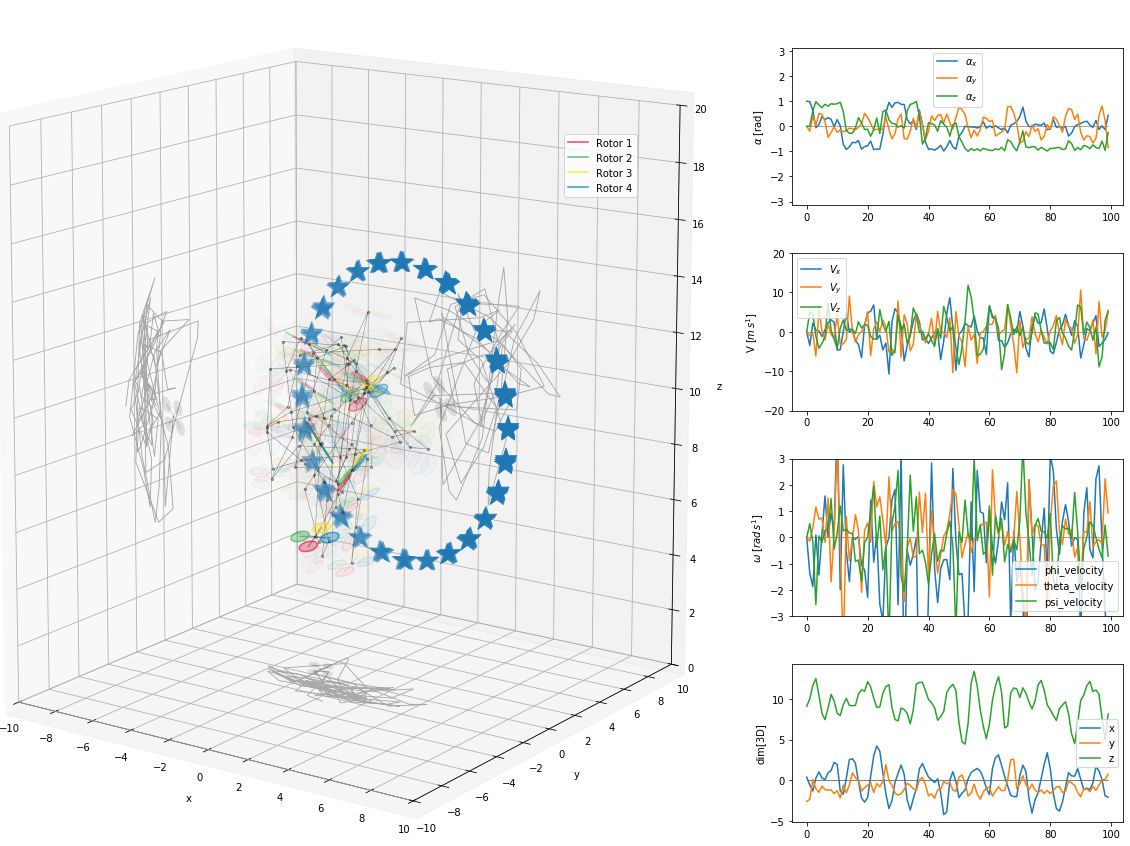

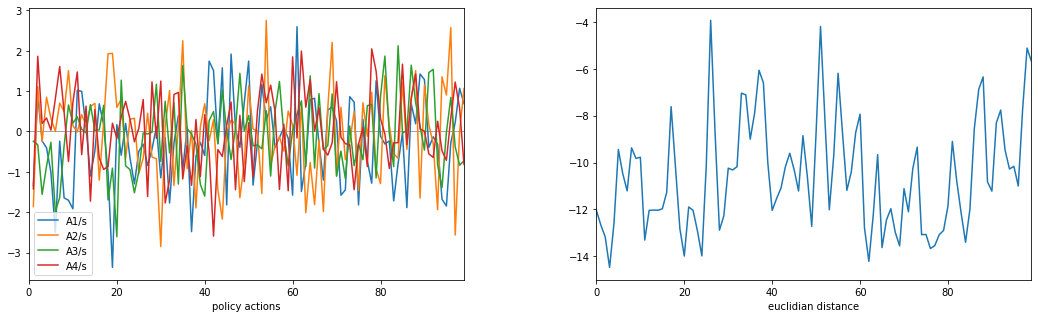

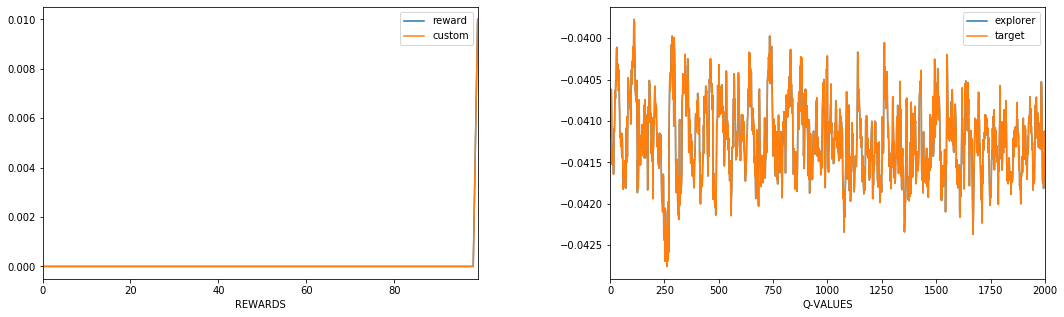

[   19>  1139:: 0] steps =   59, max_step =  60/ 60, reward=0.033000 <action=tensor([ 1.4193,  2.4049,  5.5143, -8.1083])>                                    
	 [ 19 ] < 221.54 sec > TEST ==>  [[tensor(0.1125)], [tensor(0.1155)]] exploring score: tensor(0.0330)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   137.23ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   137.21ms/cyc @     0.3execs/cyc
                    learn: 100.0%   137.20ms/cyc @     0.3execs/cyc
        FullMemory-sample:  76.3%   104.66ms/cyc @     0.1execs/cyc
            _push_to_fast:  65.9%    90.46ms/cyc @    13.6execs/cyc
                   _learn:  25.5%    35.01ms/cyc @     0.4execs/cyc
        FastMemory-sample:  23.7%    32.49ms/cyc @     0.2execs/cyc
                 __call__:  22.8%    31.32ms/cyc @    13.9execs/cyc
                 backprop:  11.5%    15.81ms/cyc @     0.8execs/cyc
                    _push:   2.9%     3.99ms/cyc @     0.3execs/cyc
            c

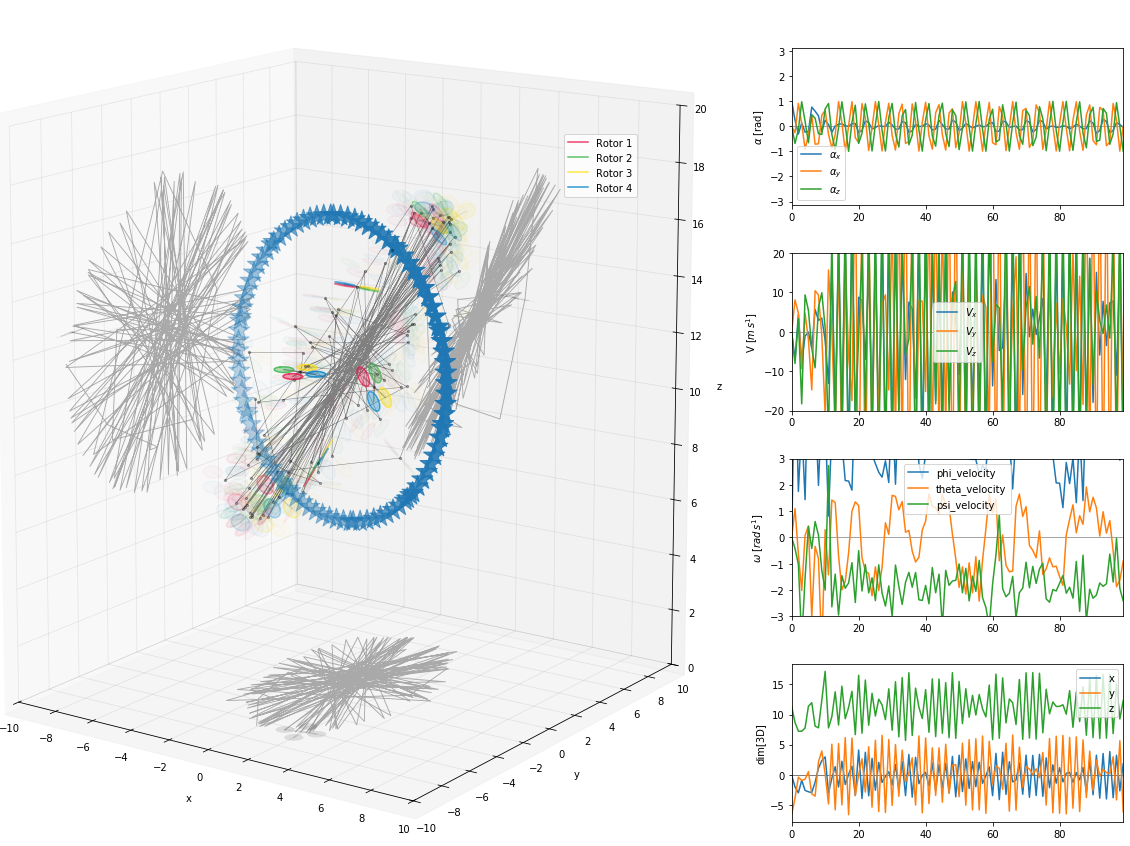

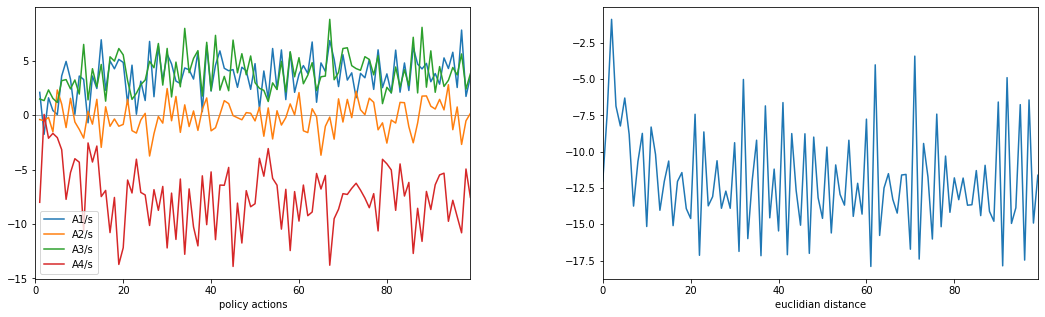

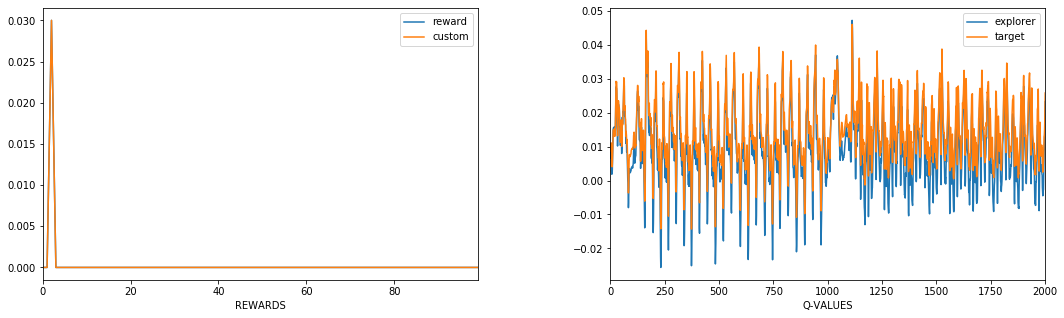

[   37>  2219:: 0] steps =   59, max_step =  60/ 60, reward=0.021500 <action=tensor([  2.5163,   0.0473,   6.1632, -11.8413])>                                

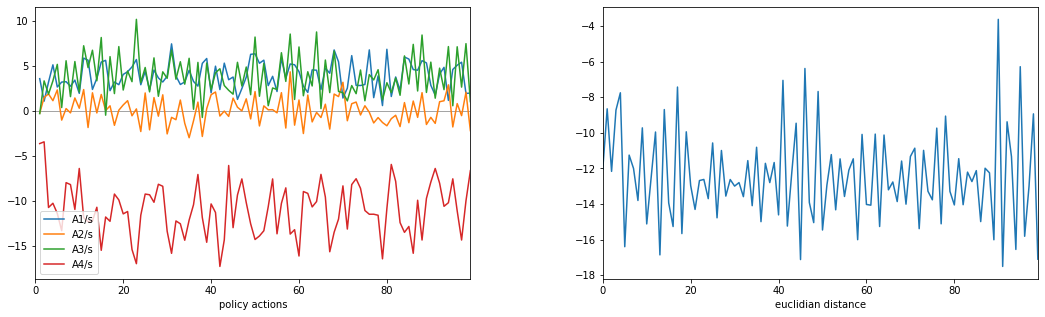

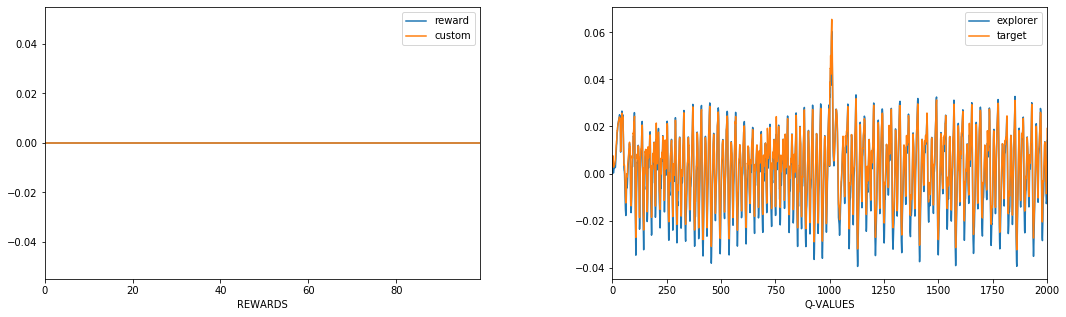

[   41>  2459:: 0] steps =   59, max_step =  60/ 60, reward=0.050500 <action=tensor([-0.2027,  1.5099,  3.1174, -2.9868])>                        
 GAHIL LEARN ROUND :: last=0.28 test=0.13 targets=-0.01 mix=-0.94 (experiences T:4682 .. O:100000)
[   45>  2649:: 0] steps =    9, max_step =  60/ 60, reward=0.000000 <action=tensor([ 5.7849,  0.9529,  2.8067, -9.4566])>                                    
 GAHIL LEARN ROUND :: last=0.37 test=0.21 targets=0.29 mix=-1.01 (experiences T:5216 .. O:100000)
[   47>  2819:: 0] steps =   59, max_step =  60/ 60, reward=0.012000 <action=tensor([  9.3411,   1.3348,   1.4150, -11.9050])>                                
 GAHIL LEARN ROUND :: last=0.01 test=0.16 targets=0.31 mix=-1.14 (experiences T:5881 .. O:100000)
[   52>  3079:: 0] steps =   19, max_step =  60/ 60, reward=0.016000 <action=tensor([-0.9097, -1.0772,  0.5286,  0.7562])>                                    
 GAHIL LEARN ROUND :: last=-0.08 test=0.11 targets=0.27 mix=-1.27 (experiences T:

[  101>  6059:: 0] steps =   59, max_step =  60/ 60, reward=0.110000 <action=tensor([ 3.5970, -1.6924, -0.7673, -2.1714])>                        
 GAHIL LEARN ROUND :: last=-0.25 test=-0.15 targets=0.13 mix=-1.76 (experiences T:23189 .. O:100000)
[  105>  6269:: 0] steps =   29, max_step =  60/ 60, reward=0.034000 <action=tensor([ 0.1803, -0.5172, -1.5392, -1.7493])>                    
 GAHIL LEARN ROUND :: last=-0.14 test=-0.15 targets=0.12 mix=-1.77 (experiences T:24398 .. O:100000)
[  107>  6369:: 0] steps =    9, max_step =  60/ 60, reward=0.000000 <action=tensor([ 2.7312,  0.1991, -0.1911, -7.7305])>                        
 GAHIL LEARN ROUND :: last=-0.30 test=-0.15 targets=0.12 mix=-1.77 (experiences T:25944 .. O:100000)
[  110>  6569:: 0] steps =   29, max_step =  60/ 60, reward=0.053500 <action=tensor([ 0.6593, -3.4177, -0.7667, -1.6221])>                        
 GAHIL LEARN ROUND :: last=0.01 test=-0.15 targets=0.12 mix=-1.77 (experiences T:27246 .. O:100000)
[  112>  6719

[  180> 10799:: 0] steps =   59, max_step =  60/ 60, reward=0.253000 <action=tensor([ 3.2295, -2.0322, -0.8138, -5.3064])>                        
 GAHIL LEARN ROUND :: last=0.01 test=-0.15 targets=0.12 mix=-1.77 (experiences T:40000 .. O:100000)
[  182> 10919:: 0] steps =   59, max_step =  60/ 60, reward=0.144000 <action=tensor([ 1.7292, -3.9604, -2.3684, -0.4144])>                        
 GAHIL LEARN ROUND :: last=-0.11 test=-0.14 targets=0.12 mix=-1.77 (experiences T:40000 .. O:100000)
[  187> 11219:: 0] steps =   59, max_step =  60/ 60, reward=0.240000 <action=tensor([-0.3173, -3.1176, -1.6228, -0.8116])>                                    
 GAHIL LEARN ROUND :: last=-0.12 test=-0.14 targets=0.12 mix=-1.77 (experiences T:40000 .. O:100000)
[  189> 11339:: 0] steps =   59, max_step =  60/ 60, reward=0.264000 <action=tensor([ 0.1016, -2.4845, -0.6372, -2.9890])>                                    
 GAHIL LEARN ROUND :: last=0.08 test=-0.14 targets=0.12 mix=-1.77 (experiences T:40000

[  240> 14399:: 0] steps =   59, max_step =  60/ 60, reward=0.287000 <action=tensor([-0.9773,  0.8427,  3.1525,  2.7961])>                    
 GAHIL LEARN ROUND :: last=-0.02 test=-0.12 targets=0.12 mix=-1.74 (experiences T:40000 .. O:100000)
[  243> 14529:: 0] steps =    9, max_step =  60/ 60, reward=0.000000 <action=tensor([ 4.4049, -0.4203, -3.0696, -9.7273])>                                    
 GAHIL LEARN ROUND :: last=0.07 test=-0.11 targets=0.12 mix=-1.74 (experiences T:40000 .. O:100000)
[  247> 14779:: 0] steps =   19, max_step =  60/ 60, reward=0.098000 <action=tensor([ -0.4839,   1.8258,   1.8204, -11.3290])>                    
 GAHIL LEARN ROUND :: last=0.06 test=-0.11 targets=0.12 mix=-1.74 (experiences T:40000 .. O:100000)
[  250> 14949:: 0] steps =    9, max_step =  60/ 60, reward=0.000000 <action=tensor([-0.9024,  3.3084, -4.6670,  0.3339])>                                    
 GAHIL LEARN ROUND :: last=-0.02 test=-0.11 targets=0.12 mix=-1.73 (experiences T:40000 .. 

[  321> 19219:: 0] steps =   19, max_step =  60/ 60, reward=0.088500 <action=tensor([ 1.7127,  0.3850, -1.1466, -3.9286])>                        
 GAHIL LEARN ROUND :: last=0.11 test=-0.08 targets=0.11 mix=-1.67 (experiences T:40000 .. O:100000)
[  322> 19319:: 0] steps =   59, max_step =  60/ 60, reward=0.579500 <action=tensor([ 0.2101,  0.0747, -2.3556, -5.4158])>                        
 GAHIL LEARN ROUND :: last=-0.05 test=-0.07 targets=0.11 mix=-1.66 (experiences T:40000 .. O:100000)
[  326> 19549:: 0] steps =   49, max_step =  60/ 60, reward=0.395000 <action=tensor([2.0365, 0.6298, 1.6027, 1.7455])>                                        
 GAHIL LEARN ROUND :: last=0.11 test=-0.07 targets=0.11 mix=-1.66 (experiences T:40000 .. O:100000)
[  330> 19779:: 0] steps =   39, max_step =  60/ 60, reward=0.387500 <action=tensor([-0.7931, -0.3782,  3.2754, -3.3899])>                                    
 GAHIL LEARN ROUND :: last=0.05 test=-0.07 targets=0.11 mix=-1.65 (experiences T:40000 

[  400> 23999:: 0] steps =   59, max_step =  60/ 60, reward=1.098000 <action=tensor([-0.2539, -4.8736, -4.4508,  6.4076])>                                    
 GAHIL LEARN ROUND :: last=0.22 test=-0.03 targets=0.11 mix=-1.55 (experiences T:40000 .. O:100000)
[  403> 24179:: 0] steps =   59, max_step =  60/ 60, reward=1.237000 <action=tensor([-0.7945,  4.4435,  0.4576,  1.1340])>                                    
 GAHIL LEARN ROUND :: last=0.09 test=-0.03 targets=0.11 mix=-1.54 (experiences T:40000 .. O:100000)
[  407> 24389:: 0] steps =   29, max_step =  60/ 60, reward=0.387500 <action=tensor([ 2.4953,  1.7156,  4.4898, -1.1803])>                                    
 GAHIL LEARN ROUND :: last=0.08 test=-0.02 targets=0.11 mix=-1.54 (experiences T:40000 .. O:100000)
[  410> 24599:: 0] steps =   59, max_step =  60/ 60, reward=0.699000 <action=tensor([-4.3491,  0.6517,  4.7532, -2.7196])>                                    
 GAHIL LEARN ROUND :: last=0.11 test=-0.02 targets=0.11 mix=-1.5

[  462> 27689:: 0] steps =   29, max_step =  60/ 60, reward=0.347000 <action=tensor([-3.9946, -1.3102, -2.9257,  7.0033])>                                    
 GAHIL LEARN ROUND :: last=0.02 test=0.02 targets=0.11 mix=-1.46 (experiences T:40000 .. O:100000)
[  465> 27879:: 0] steps =   39, max_step =  60/ 60, reward=0.641000 <action=tensor([ 2.7469, -3.6289, -4.8258, -2.9996])>                        
 GAHIL LEARN ROUND :: last=0.04 test=0.02 targets=0.11 mix=-1.46 (experiences T:40000 .. O:100000)
[  467> 28019:: 0] steps =   59, max_step =  60/ 60, reward=1.212000 <action=tensor([ 2.8423, -0.9256, -1.4397,  4.2713])>                        
 GAHIL LEARN ROUND :: last=0.05 test=0.02 targets=0.11 mix=-1.46 (experiences T:40000 .. O:100000)
[  470> 28169:: 0] steps =   29, max_step =  60/ 60, reward=0.291000 <action=tensor([ 0.7615,  0.2787, -0.0238, -2.2204])>                                    
 GAHIL LEARN ROUND :: last=0.15 test=0.03 targets=0.11 mix=-1.46 (experiences T:40000 .. O:

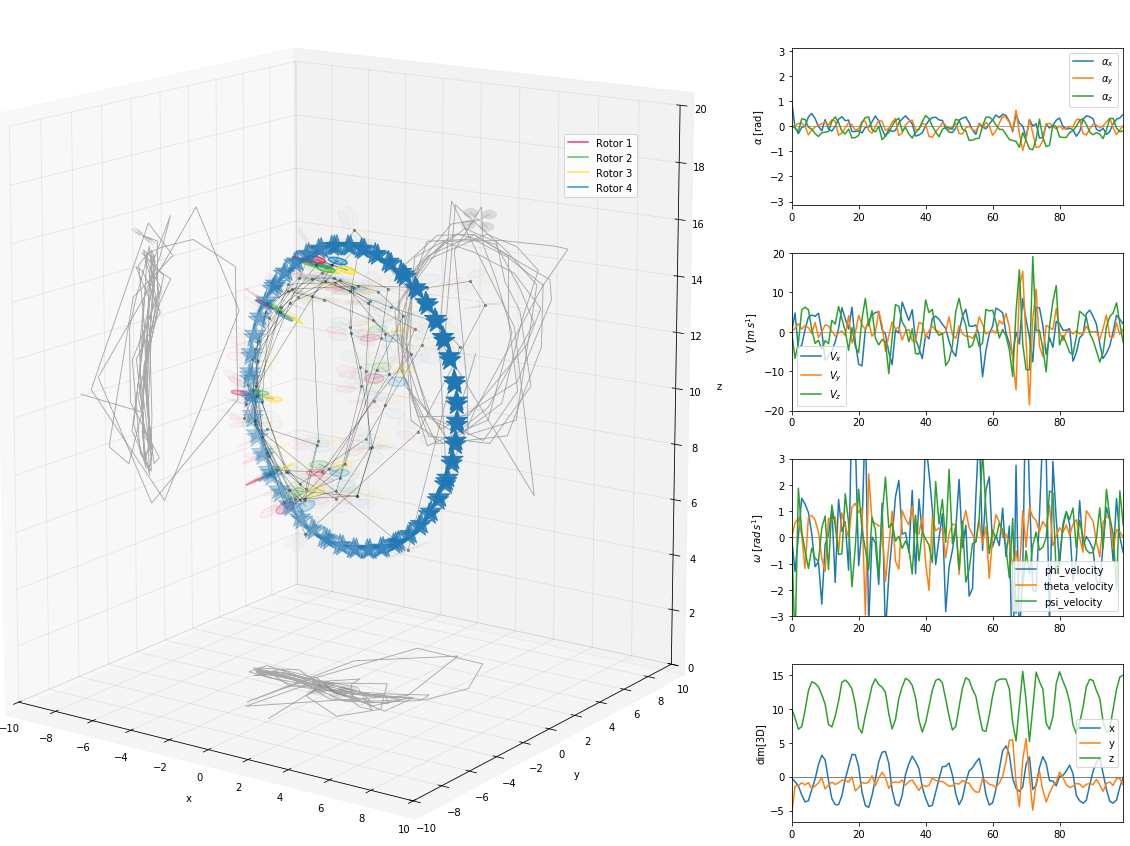

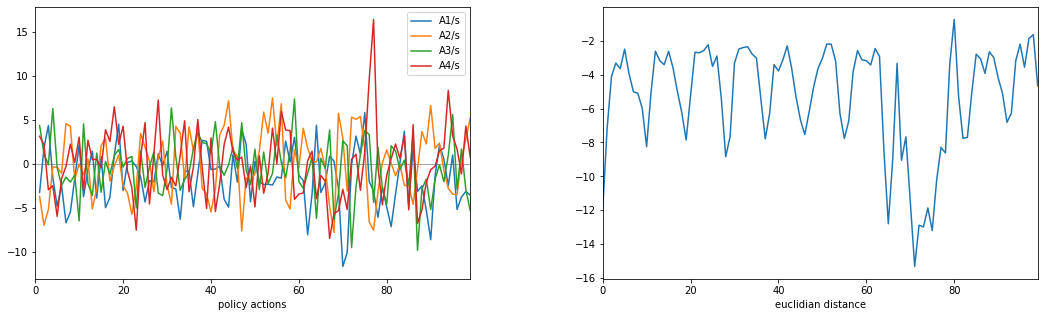

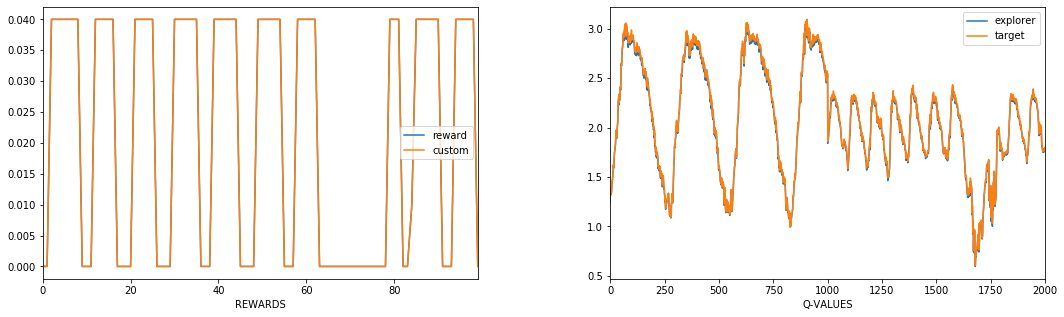

[  521> 31239:: 0] steps =   39, max_step =  60/ 60, reward=0.810500 <action=tensor([-3.2630,  1.0283,  0.9616,  2.0747])>                        
 GAHIL LEARN ROUND :: last=0.14 test=0.05 targets=0.11 mix=-1.36 (experiences T:40000 .. O:100000)
[  524> 31429:: 0] steps =   49, max_step =  60/ 60, reward=1.231000 <action=tensor([-5.8958, -4.0561,  6.1424, -3.1825])>                        
 GAHIL LEARN ROUND :: last=-0.06 test=0.05 targets=0.11 mix=-1.35 (experiences T:40000 .. O:100000)
[  526> 31559:: 0] steps =   59, max_step =  60/ 60, reward=1.300000 <action=tensor([ 3.0109, -0.7070, -2.8120, -2.2779])>                                    
 GAHIL LEARN ROUND :: last=0.23 test=0.05 targets=0.11 mix=-1.35 (experiences T:40000 .. O:100000)
[  529> 31739:: 0] steps =   59, max_step =  60/ 60, reward=1.411000 <action=tensor([1.4999, 3.0324, 2.7373, 1.7297])>                                        
 GAHIL LEARN ROUND :: last=0.02 test=0.05 targets=0.11 mix=-1.34 (experiences T:40000 .. O

In [10]:
agent, env = new_agent(
    [4, 1], bpo_brain, lr_critic=5e-5,
    goal_encoder=goal_encoder, encoder=encoder, freeze_delta=3, freeze_count=3, 
    action_size=4, n_rewards=N_REWARDS, n_step=N_STEP, max_steps=MAX_STEPS,
    detach_actors=True, detach_critics=False, stable_probs=False,
    good_reach=1, model_path="checkpoints", save=True, load=False
    )
scores = env.start(task, callback)

In [11]:
losses = agent.brain.losses
scores_ex = scores[1:]
scores = np.asarray(scores_ex).flatten()
losses_ex = losses
losses = np.vstack(losses_ex)[::len(losses_ex)//200]

### 10. Plot training reward + loss

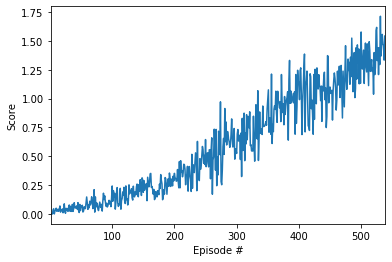

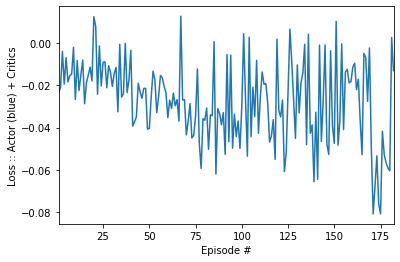

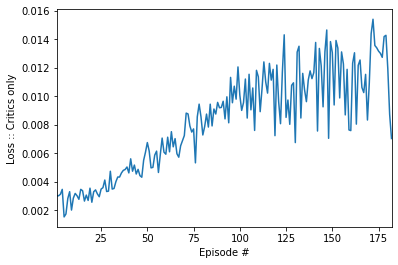

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show() 

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(losses) - len(losses) // 10+1), losses[len(losses) // 10:, 0])
plt.ylabel('Loss :: Actor (blue) + Critics')
plt.xlabel('Episode #')
plt.show() 

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(losses) - len(losses) // 10+1), losses[len(losses) // 10:, 1:])
plt.ylabel('Loss :: Critics only')
plt.xlabel('Episode #')
plt.show() 

### 11. Reload trained agent

In [13]:
agent.sync_target(0, [])
agent.sync_explorer(0, [])

### 12. Test visuals - TARGET


 environment solved!  31.4817242963286 [array([32.21099928, 30.75244931])]
[[tensor(30.9680), tensor(32.3500), tensor(32.6870), tensor(33.0740), tensor(31.8375), tensor(32.9120), tensor(32.1970), tensor(32.7100), tensor(33.1595), tensor(30.2150)], [tensor(30.3520), tensor(31.4640), tensor(29.9690), tensor(29.1595), tensor(31.6215), tensor(32.2310), tensor(29.6980), tensor(31.8620), tensor(31.2275), tensor(29.9400)]]

 environment solved!  31.368399298861608 [array([31.5401493, 31.1966493])]
[[tensor(29.8505), tensor(33.1910), tensor(31.1130), tensor(30.8370), tensor(33.2840), tensor(33.2910), tensor(31.7175), tensor(31.1025), tensor(29.8685), tensor(31.1465)], [tensor(31.6280), tensor(31.2215), tensor(32.3190), tensor(30.2595), tensor(30.0235), tensor(32.2670), tensor(31.2175), tensor(30.4465), tensor(31.8020), tensor(30.7820)]]

 environment solved!  31.578949294155443 [array([31.84819929, 31.3096993 ])]
[[tensor(33.3940), tensor(31.4655), tensor(32.0795), tensor(31.7190), tensor(31.

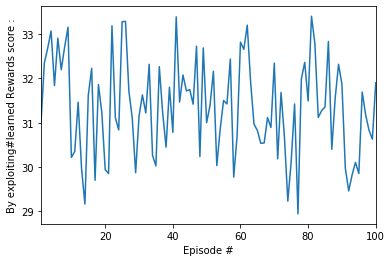

In [14]:
rewards = []
while len(rewards) < 100:
    success, scores = env.evaluate(task)
    [ rewards.extend(score) for score in scores ]
        
print("mean rewards : ", np.mean(rewards))
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(rewards)+1), rewards)
plt.ylabel('By exploiting#learned Rewards score :')
plt.xlabel('Episode #')
plt.show()

### 13. Test visuals - EXPLORER


 environment solved!  31.554399294704194 [array([32.02724928, 31.08154931])]
[[tensor(32.6805), tensor(32.7340), tensor(32.4775), tensor(30.2210), tensor(32.8665), tensor(31.7370), tensor(32.1665), tensor(31.1270), tensor(30.9800), tensor(33.2825)], [tensor(31.3990), tensor(31.1835), tensor(30.5890), tensor(30.6145), tensor(31.0190), tensor(30.2425), tensor(30.6430), tensor(32.5160), tensor(31.7630), tensor(30.8460)]]

 environment solved!  31.1179993044585 [array([31.1337993, 31.1021993])]
[[tensor(31.1855), tensor(28.4050), tensor(30.9520), tensor(30.7645), tensor(31.4085), tensor(31.8320), tensor(30.5710), tensor(32.3720), tensor(32.6270), tensor(31.2205)], [tensor(32.1175), tensor(30.6570), tensor(31.1070), tensor(32.1795), tensor(31.1425), tensor(30.6585), tensor(30.7550), tensor(31.4535), tensor(31.4280), tensor(29.5235)]]

 environment solved!  31.549199294820397 [array([31.5147993 , 31.58359929])]
[[tensor(32.1210), tensor(32.7295), tensor(30.3710), tensor(30.9730), tensor(32.

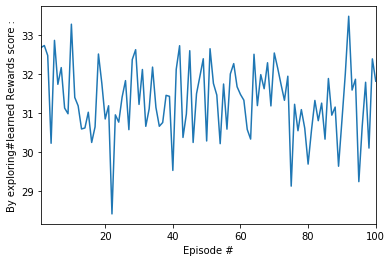

In [15]:
# for evaluation we will set target network to be explorer
agent.brain.ac_target = agent.brain.ac_explorer

rewards = []
while len(rewards) < 100:
    success, scores = env.evaluate(task)
    [ rewards.extend(score) for score in scores ]
        
print("mean rewards : ", np.mean(rewards))
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(rewards)+1), rewards)
plt.ylabel('By exploring#learned Rewards score :')
plt.xlabel('Episode #')
plt.show()